In [1]:
import os
import sys
os.chdir("../../.")

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("customstyle.mplstyle")
import pandas as pd
sys.path.append("modules")
from PBD_analog import fixedZero_PBD_to_varBD
from math import ceil

# Full PBD model

Get the PBD parameter values used for simulations.

In [3]:
# Load parameters from CSV
data = pd.read_csv("2-simulate_trees/3-varBD/sim_parameters.csv")

data.head()

,Unnamed: 0,param_vary,i_param_var,replicate,PBD.l1,PBD.l2,PBD.l3,PBD.mu1,PBD.mu2
0,1,1,1,NaN,0.050000,1.0,0.4,0.2,0.2
1,2,1,2,NaN,0.158114,1.0,0.4,0.2,0.2
2,3,1,3,NaN,0.500000,1.0,0.4,0.2,0.2
3,4,1,4,NaN,0.792447,1.0,0.4,0.2,0.2
4,5,1,5,NaN,1.255943,1.0,0.4,0.2,0.2


Construct the corresponding variable BD rates.

/Users/Jeremy/miniconda/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
/Users/Jeremy/Nextcloud/Recherche/1_Methods/PBD_analog/modules/PBD_analog.py:140: RuntimeWarning: invalid value encountered in sqrt
  pIE =  1/b * np.sqrt(num/den - 0.5*(l*(k-l) + 2*a*b))


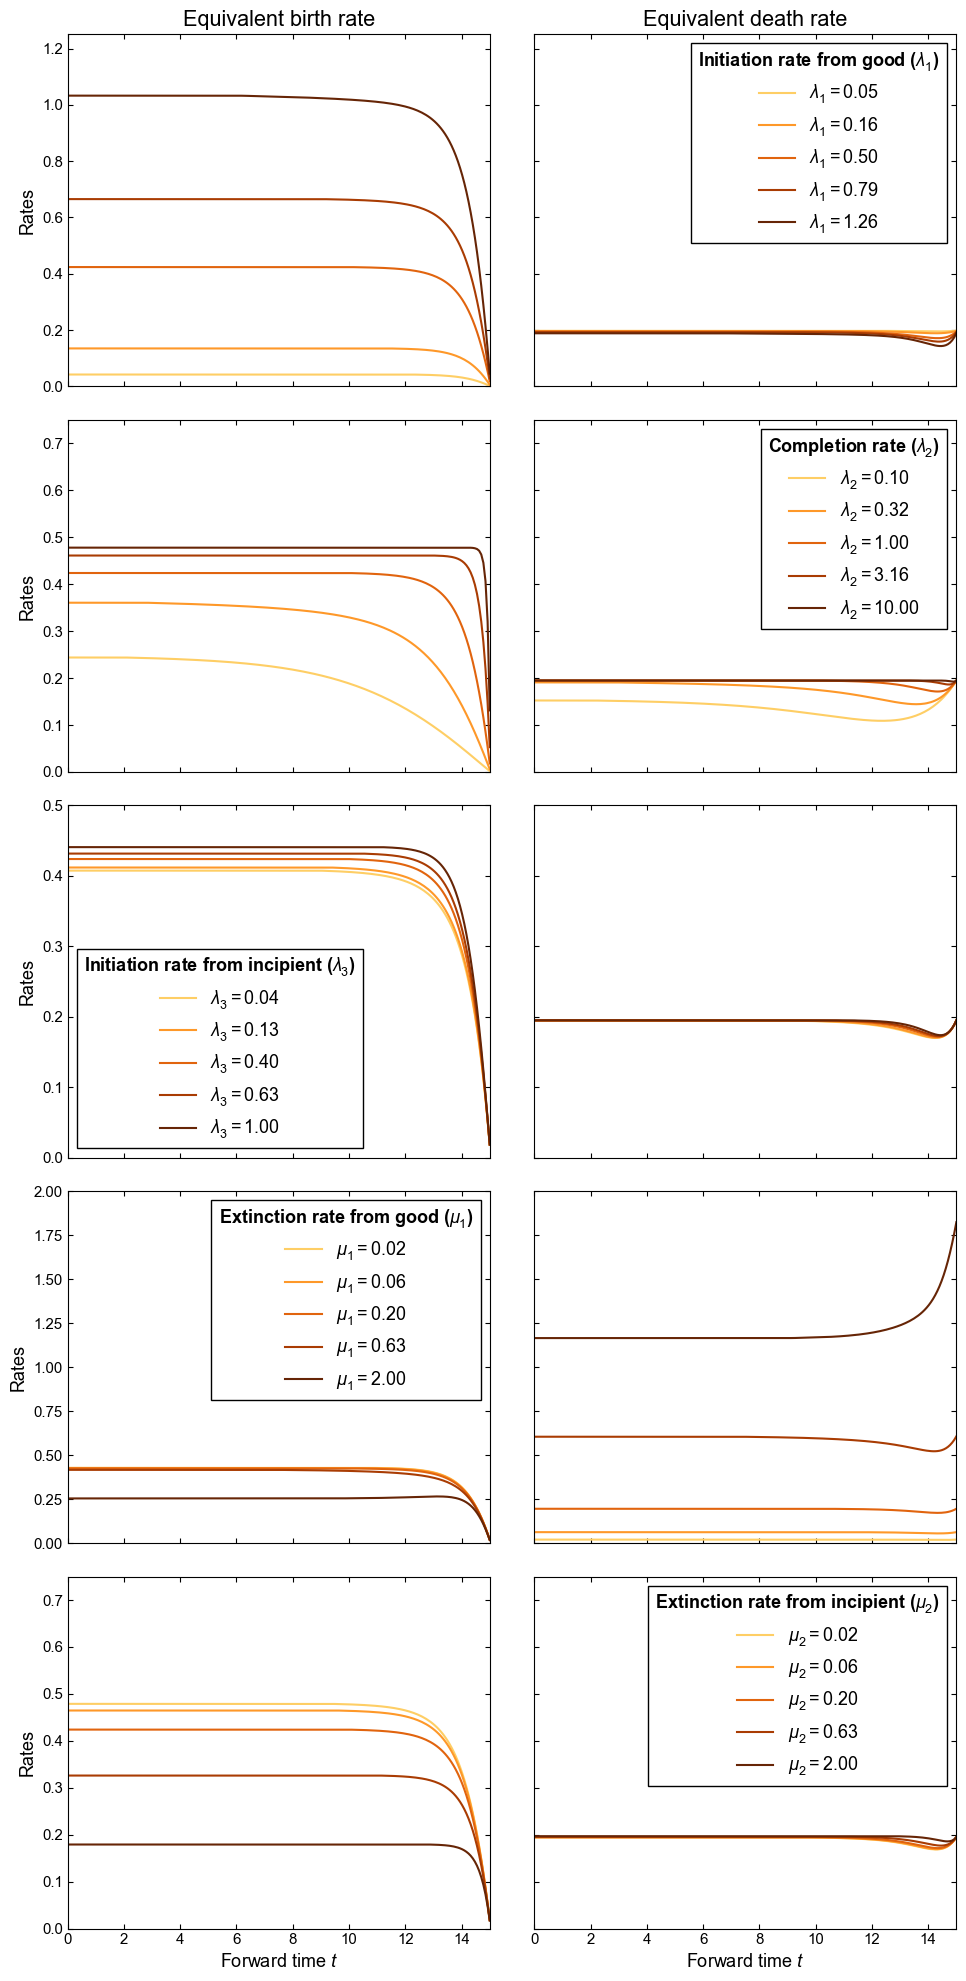

In [4]:
parameter_columns = ["l1", "l2", "l3", "m1", "m2"]

labels = ["\\lambda_1", "\\lambda_2", "\\lambda_3", "\\mu_1", "\\mu_2"]
titles = [r"Initiation rate from good ($\lambda_1$)", r"Completion rate ($\lambda_2$)", r"Initiation rate from incipient ($\lambda_3$)", 
          r"Extinction rate from good ($\mu_1$)", r"Extinction rate from incipient ($\mu_2$)"]
cmap = mpl.colormaps["YlOrBr"]
T = np.linspace(0, 15, 200)

#fig, axes = plt.subplots(len(parameter_columns), 2, sharex=True, sharey=True, figsize=(10, 20))
fig, axes = plt.subplots(len(parameter_columns), 2, sharex=True, sharey="row", figsize=(10, 20))
all_rates = []
for i, parameter in enumerate(parameter_columns):
    # Filter data to include only the rows where 'param_vary' matches the current parameter index (1-based)
    varying_data = data[data["param_vary"] == (i + 1)]

    if not varying_data.empty:  # Only proceed if there are rows where the parameter varies
        for index, row in varying_data.iterrows():
            # Extract the relevant parameters
            par_copy = {
                'l1': row["PBD.l1"],
                'l2': row["PBD.l2"],
                'l3': row["PBD.l3"],
                'm1': row["PBD.mu1"],
                'm2': row["PBD.mu2"]
            }

            l_equiv, m_equiv = fixedZero_PBD_to_varBD(T, **par_copy, 
                                                          solver_kwargs = dict(atol = 1e-13, rtol = 1e-15), 
                                                          conv_crit = dict(tol = 1e-4, w = 2, silent = False))
            lbl = "${} = {:.2f}$".format(labels[i], par_copy[parameter])

            # Plot equivalent birth and death rates
            axes[i, 0].plot(T, l_equiv, label=lbl, color=cmap((index - i * len(varying_data) + 2) / (1 + len(varying_data))))
            axes[i, 1].plot(T, m_equiv, label=lbl, color=cmap((index - i * len(varying_data) + 2) / (1 + len(varying_data))))

            # Collect rates for saving
            rate_info = {
                'parameter': parameter,
                'parameter_value': par_copy[parameter],
                'birth_rate': l_equiv,
                'death_rate': m_equiv
            }
            all_rates.append(rate_info)
        if i in (2,3): # optimize position of the legend
            j = 0
            if i == 2:
                loc = 3
            else: 
                loc = 1
        else:
            j, loc = 1, 1
        lg = axes[i, j].legend(loc=loc, title=titles[i], title_fontproperties=dict(weight='bold'))

    axes[i, 0].set_ylabel("Rates")
    y_max = max(ceil(axes[i,0].get_ylim()[1]*4)/4, ceil(axes[i,1].get_ylim()[1]*4)/4)
    axes[i, 0].set_ylim(0, y_max)
    axes[i, 1].set_ylim(0, y_max)

    for k in (0, 1):
        axes[i, k].tick_params(axis="both", direction="in")
        axes[i, k].yaxis.set_ticks_position('both')
        axes[i, k].xaxis.set_ticks_position('both')

axes[0, 0].set_title("Equivalent birth rate")
axes[0, 1].set_title("Equivalent death rate")
axes[-1, 0].set_xlabel("Forward time $t$")
axes[-1, 1].set_xlabel("Forward time $t$")
axes[0, 0].set_xlim(T[0], T[-1])

plt.tight_layout()
plt.savefig("fig/SM_time_dep_rates_comparison.pdf")

np.save("simulations_output/3-varBD/variable_BDrates.npy", all_rates)

# Simplified PBD model (3 parameters)

In [9]:
# Load parameters from CSV
data_3pars = pd.read_csv("2-simulate_trees/3-varBD/sim_parameters_simplified.csv")

data_3pars.head(10)

,Unnamed: 0,param_vary,i_param_var,PBD.l1,PBD.l2,PBD.l3,PBD.mu1,PBD.mu2
0,1,1,1,0.315479,1.000000,0.315479,0.2,0.2
1,2,1,2,0.397164,1.000000,0.397164,0.2,0.2
2,3,1,3,0.500000,1.000000,0.500000,0.2,0.2
3,4,1,4,0.629463,1.000000,0.629463,0.2,0.2
4,5,1,5,0.792447,1.000000,0.792447,0.2,0.2
5,6,2,1,0.500000,0.100000,0.500000,0.2,0.2
6,7,2,2,0.500000,0.316228,0.500000,0.2,0.2
7,8,2,3,0.500000,1.000000,0.500000,0.2,0.2
8,9,2,4,0.500000,3.162278,0.500000,0.2,0.2
9,10,2,5,0.500000,10.000000,0.500000,0.2,0.2


Construct the corresponding variable BD rates.

/Users/Jeremy/miniconda/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
/Users/Jeremy/Nextcloud/Recherche/1_Methods/PBD_analog/modules/PBD_analog.py:140: RuntimeWarning: invalid value encountered in sqrt
  pIE =  1/b * np.sqrt(num/den - 0.5*(l*(k-l) + 2*a*b))


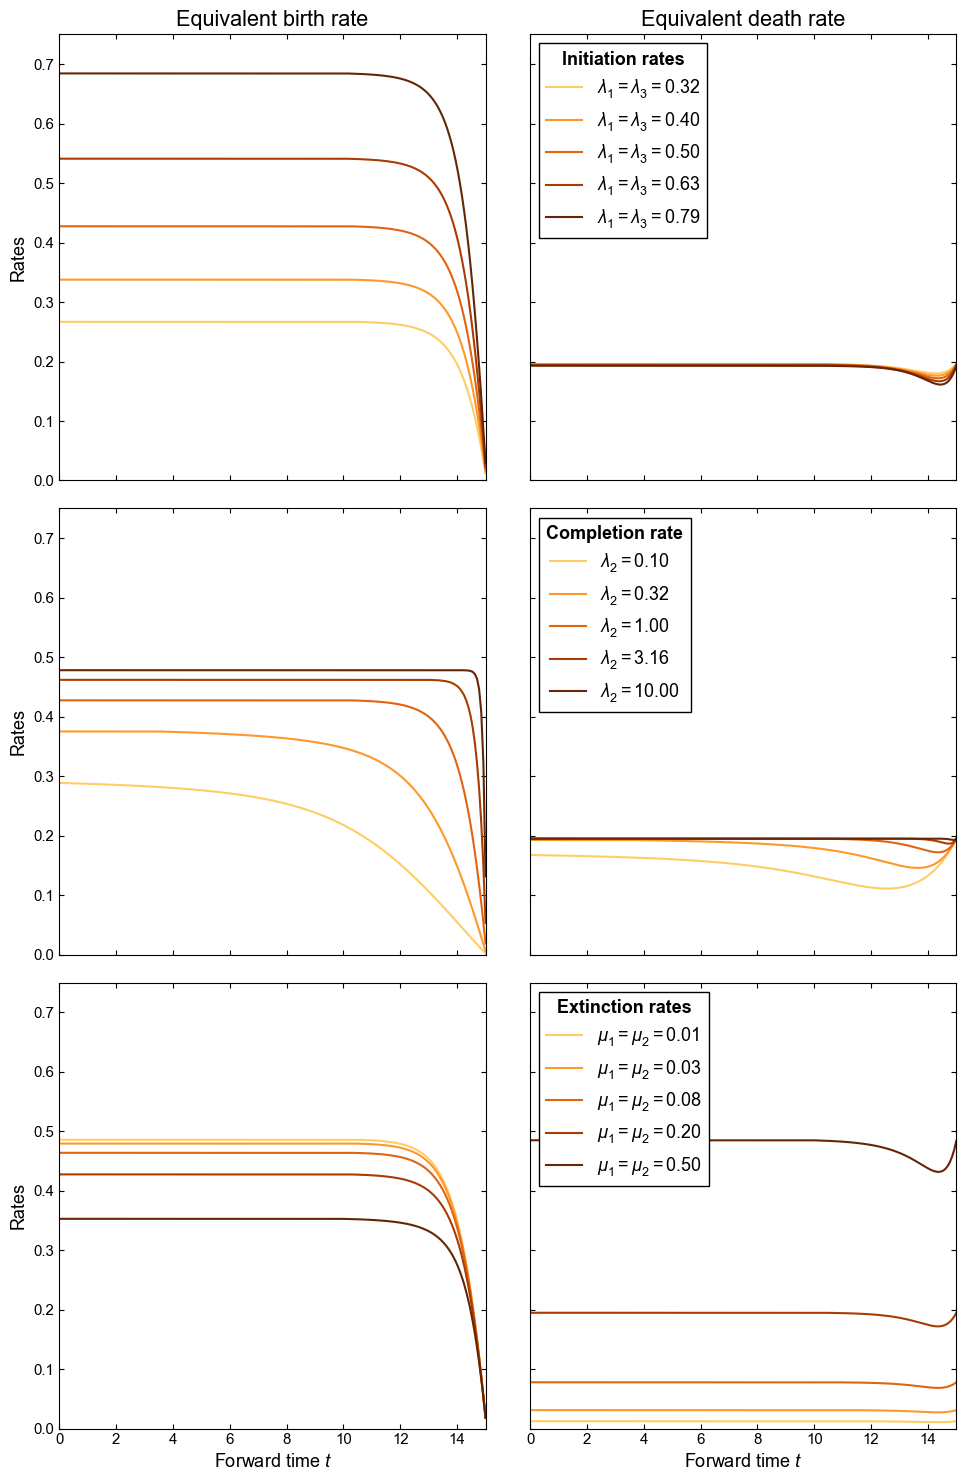

In [14]:
parameter_columns = ["l1", "l2", "m1"]

labels = ["\\lambda_1 = \\lambda_3", "\\lambda_2", "\\mu_1 = \\mu_2"]
titles = [r"Initiation rates", r"Completion rate", 
          r"Extinction rates"]
cmap = mpl.colormaps["YlOrBr"]
T = np.linspace(0, 15, 200)

#fig, axes = plt.subplots(len(parameter_columns), 2, sharex=True, sharey=True, figsize=(10, 15))
fig, axes = plt.subplots(len(parameter_columns), 2, sharex=True, sharey="row", figsize=(10, 15))
all_rates = []
for i, parameter in enumerate(parameter_columns):
    # Filter data to include only the rows where 'param_vary' matches the current parameter index (1-based)
    varying_data = data_3pars[data_3pars["param_vary"] == (i + 1)]

    if not varying_data.empty:  # Only proceed if there are rows where the parameter varies
        for index, row in varying_data.iterrows():
            # Extract the relevant parameters
            par_copy = {
                'l1': row["PBD.l1"],
                'l2': row["PBD.l2"],
                'l3': row["PBD.l3"],
                'm1': row["PBD.mu1"],
                'm2': row["PBD.mu2"]
            }

            l_equiv, m_equiv = fixedZero_PBD_to_varBD(T, **par_copy, 
                                                          solver_kwargs = dict(atol = 1e-13, rtol = 1e-15), 
                                                          conv_crit = dict(tol = 1e-4, w = 2, silent = False))
            lbl = "${} = {:.2f}$".format(labels[i], par_copy[parameter])

            # Plot equivalent birth and death rates
            axes[i, 0].plot(T, l_equiv, label=lbl, color=cmap((index - i * len(varying_data) + 2) / (1 + len(varying_data))))
            axes[i, 1].plot(T, m_equiv, label=lbl, color=cmap((index - i * len(varying_data) + 2) / (1 + len(varying_data))))

            # Collect rates for saving
            rate_info = {
                'parameter': parameter,
                'parameter_value': par_copy[parameter],
                'birth_rate': l_equiv,
                'death_rate': m_equiv
            }
            all_rates.append(rate_info)
        if i == 1: # optimize position of the legend
            j, loc = 1, 2
        elif i == 2:
            j, loc = 1, 2
        else:
            j, loc = 1, 2
        lg = axes[i, j].legend(loc=loc, title=titles[i], title_fontproperties=dict(weight='bold'))

    axes[i, 0].set_ylabel("Rates")
    y_max = max(ceil(axes[i,0].get_ylim()[1]*4)/4, ceil(axes[i,1].get_ylim()[1]*4)/4)
    axes[i, 0].set_ylim(0, y_max)
    axes[i, 1].set_ylim(0, y_max)

    for k in (0, 1):
        axes[i, k].tick_params(axis="both", direction="in")
        axes[i, k].yaxis.set_ticks_position('both')
        axes[i, k].xaxis.set_ticks_position('both')

axes[0, 0].set_title("Equivalent birth rate")
axes[0, 1].set_title("Equivalent death rate")
axes[-1, 0].set_xlabel("Forward time $t$")
axes[-1, 1].set_xlabel("Forward time $t$")
axes[0, 0].set_xlim(T[0], T[-1])

plt.tight_layout()
plt.savefig("fig/SM_time_dep_rates_comparison_simplified_PBD.pdf")

np.save("simulations_output/3-varBD/variable_BDrates_simplified_PBD.npy", all_rates)